In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

In [103]:
# define the utils

imagenet_mean = np.array([.5, .5, .5])
imagenet_std = np.array([.5, .5, .5])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint, strict=False)
    print(msg)
    return model

def run_one_image(input_img, input_mask, model):
    x = input_img
    # run MAE
    loss, y, mask = model_mae(input_img, input_mask, mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('ncthw->nthwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *6)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('ncthw->nthwc', mask).detach().cpu()
    
    x = torch.einsum('ncthw->nthwc', x)
    input_mask = torch.einsum('ncthw->nthwc',input_mask)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    print(input_mask.shape)
    
# Iterate over the rows
    for row in range(3):
        plt.subplot(3, 5, row * 5 + 1)
        show_image(x[0, row, :, :, 0:3].flip(2), f"Original at T={row}")

        plt.subplot(3, 5, row * 5 + 2)
        show_image(input_mask[0, row, :, :, 0:3], f"Input Mask at T={row}")

        plt.subplot(3, 5, row * 5 + 3)
        show_image(im_masked[0, row, :, :, 0:3].flip(2), f"Masked at t={row}")

        plt.subplot(3, 5, row * 5 + 4)
        show_image(y[0, row, :, :, 0:3].flip(2), f"Reconstruction at t={row}")

        plt.subplot(3, 5, row * 5 + 5)
        show_image(im_paste[0, row, :, :, 0:3].flip(2), f"Reconstruction + Visible at t={row}")

    plt.tight_layout()
    plt.savefig('figure.png')
    plt.show()
    


In [4]:
# Load inputs

# Define the directory containing the .pt files
directory = '/workspace/data/lchu/hls/vis/2023-07-06_02-01-18'

# List all files in the directory
file_list = os.listdir(directory)

In [92]:
# Filter for input files
tensor_files = [file for file in file_list if "input" in file]

# Load tensors from each .pt file
mask_tensors = []
img_tensors = []
for file in tensor_files:
    file_path = os.path.join(directory, file)
    tensor = torch.load(file_path)
    if "mask" in file:
        tensor[:,:,0,:,:] = 0
        tensor[:,:,2,:,:] = 0
        mask_tensors.append(tensor[0:1,:,:,:,:].repeat(1,2,1,1,1)[:,0:6,:,:,:])
    else:
        img_tensors.append(tensor[0:1,:,:,:,:].repeat(1,2,1,1,1)[:,0:6,:,:,:])

        # Access the loaded tensors
for m, i in zip(mask_tensors, img_tensors):
    print(m.shape)
    print(i.shape)

for idx, tensor in enumerate(mask_tensors):
    if idx == len(mask_tensors)-1:
        tensor[:,:,0,:,:] = mask_tensors[0][:,:,1,:,:]
        tensor[:,:,2,:,:] = mask_tensors[idx-1][:,:,1,:,:]
    elif idx == 0:
        tensor[:,:,0,:,:] = mask_tensors[idx+1][:,:,1,:,:]
        tensor[:,:,2,:,:] = mask_tensors[-1][:,:,1,:,:]
    else:
        tensor[:,:,0,:,:] = mask_tensors[idx+1][:,:,1,:,:]
        tensor[:,:,2,:,:] = mask_tensors[idx-1][:,:,1,:,:]
        


torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])
torch.Size([1, 6, 3, 224, 224])


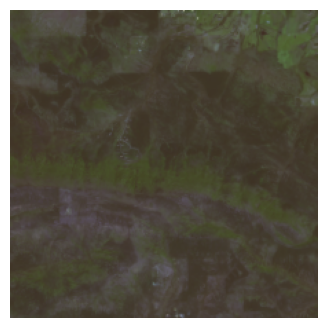

In [93]:
plt.rcParams['figure.figsize'] = [4, 4]
show_image(img_tensors[0][0,0:3,0,:,:].permute(1,2,0))

In [7]:
chkpt_dir = 'epoch-832-loss-0.0473.pt'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:
torch.Size([1, 3, 224, 224, 6])


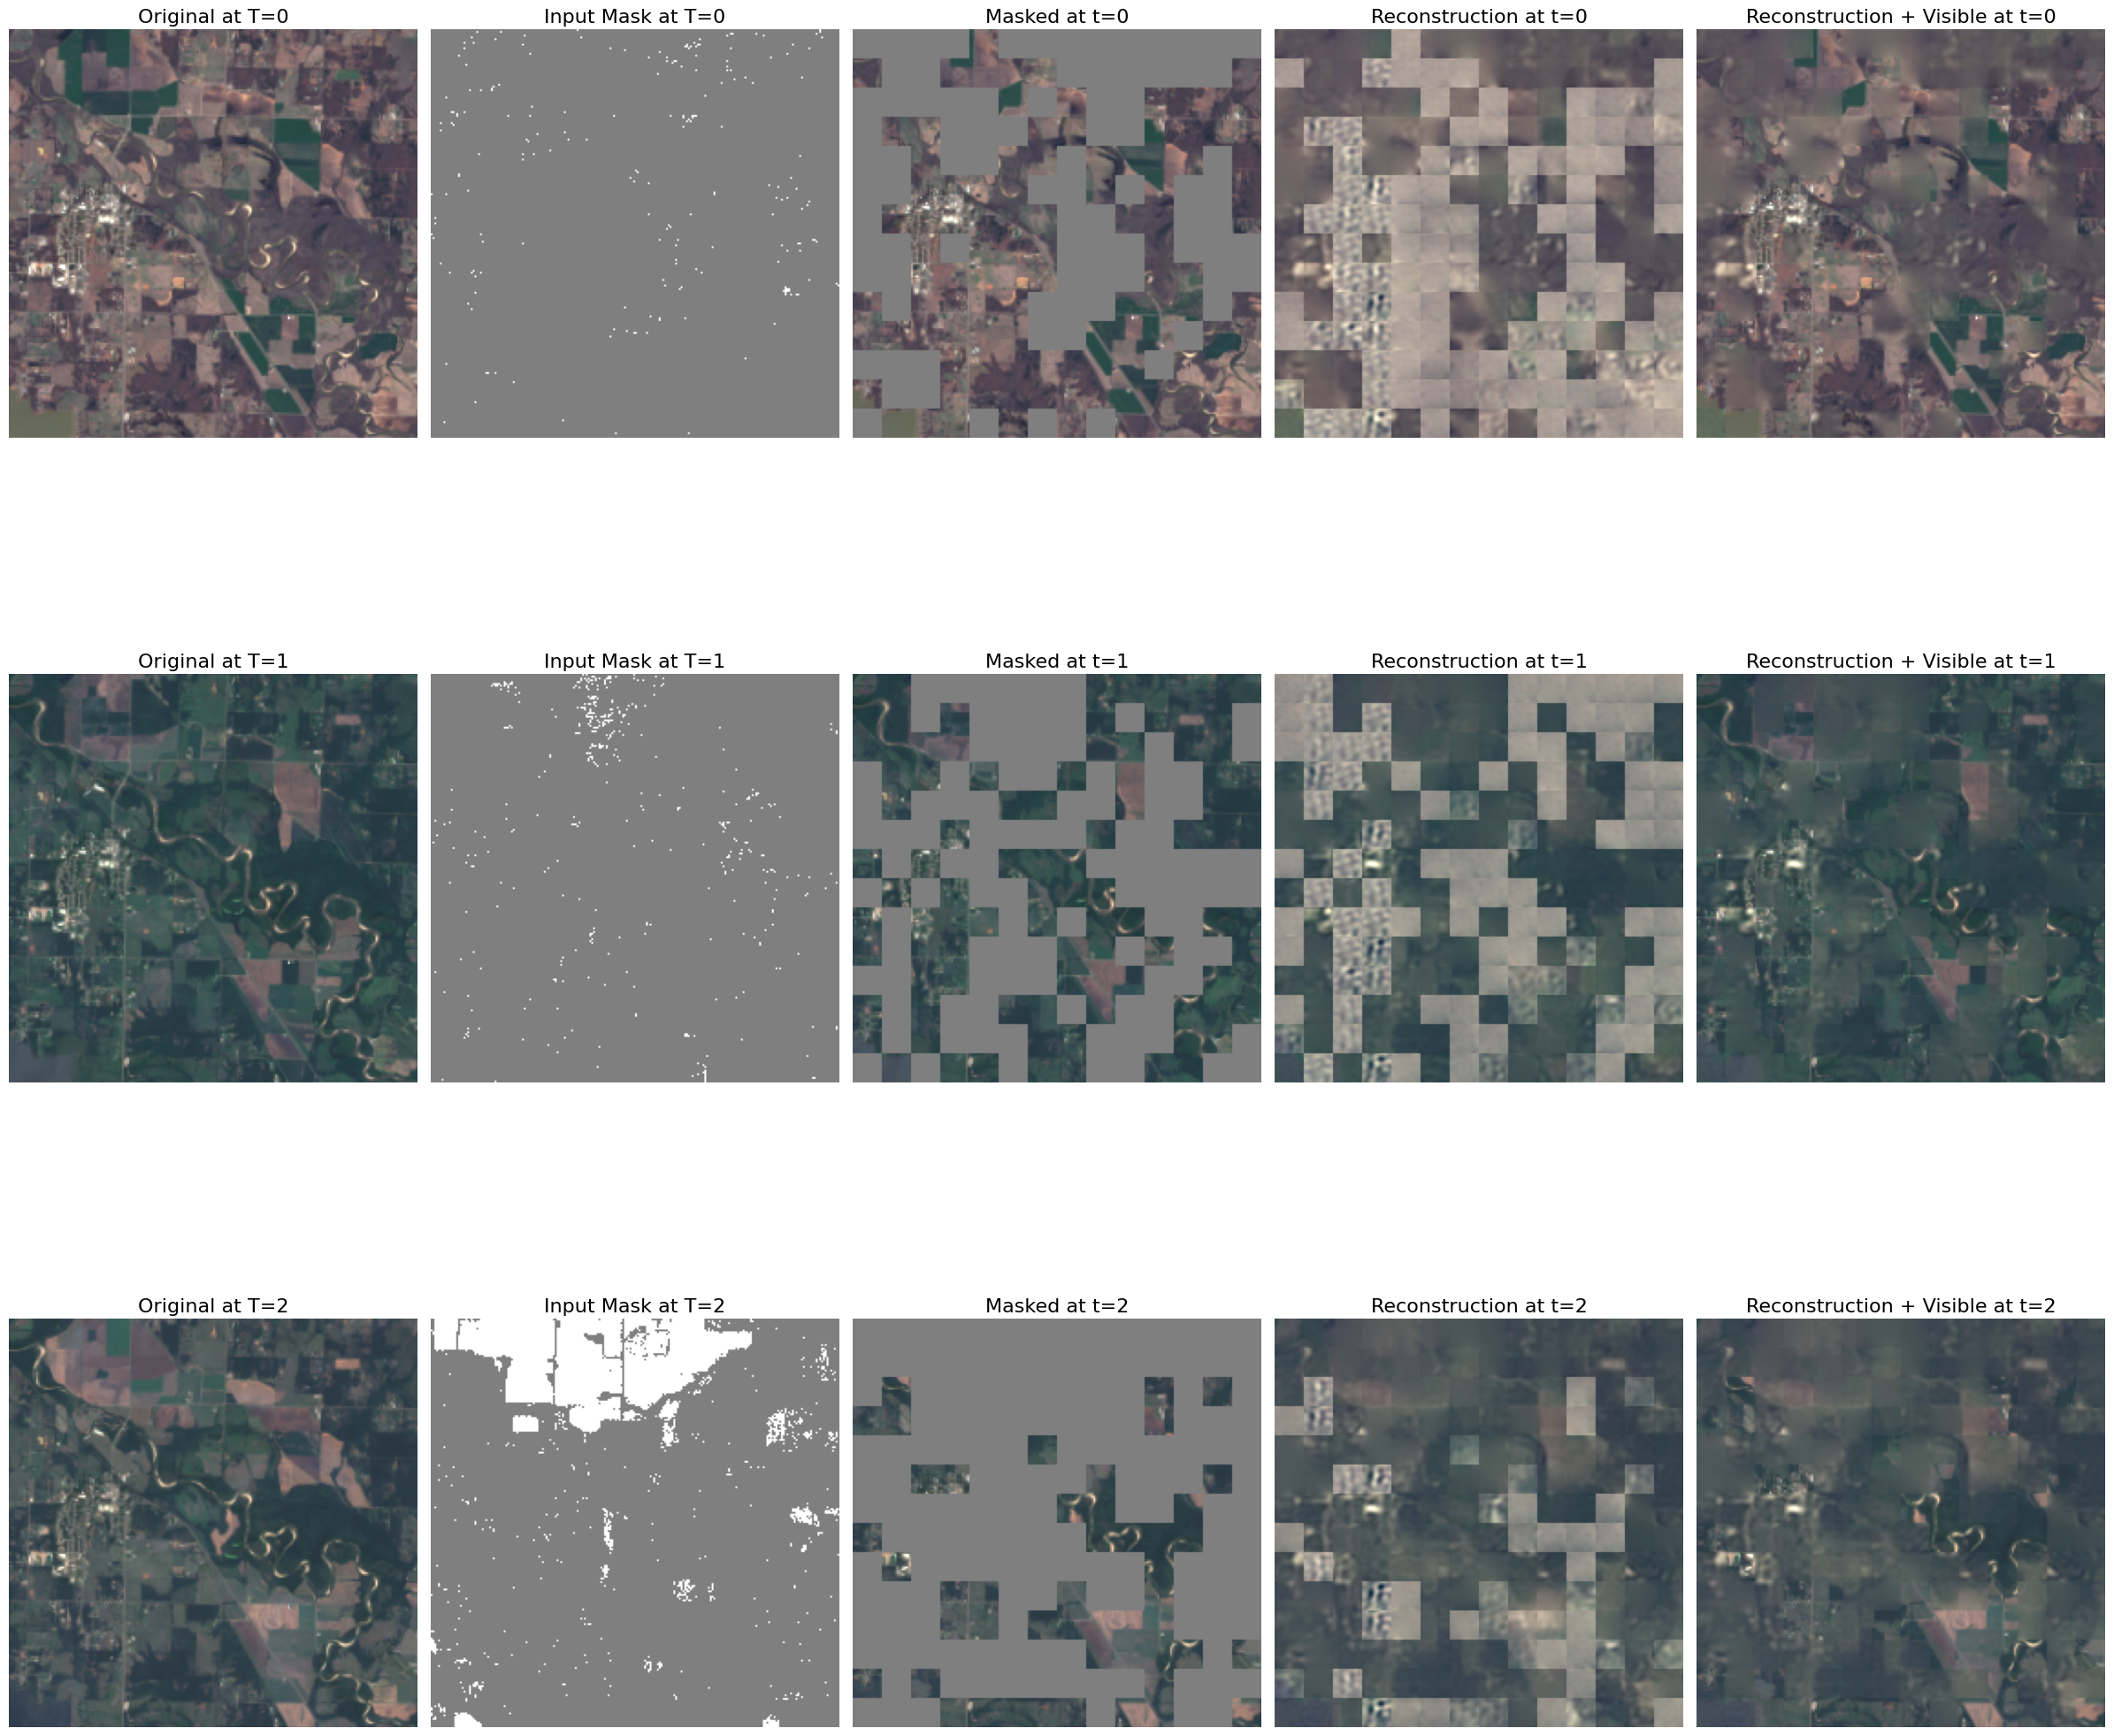

In [104]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img_tensors[4], mask_tensors[0], model_mae)

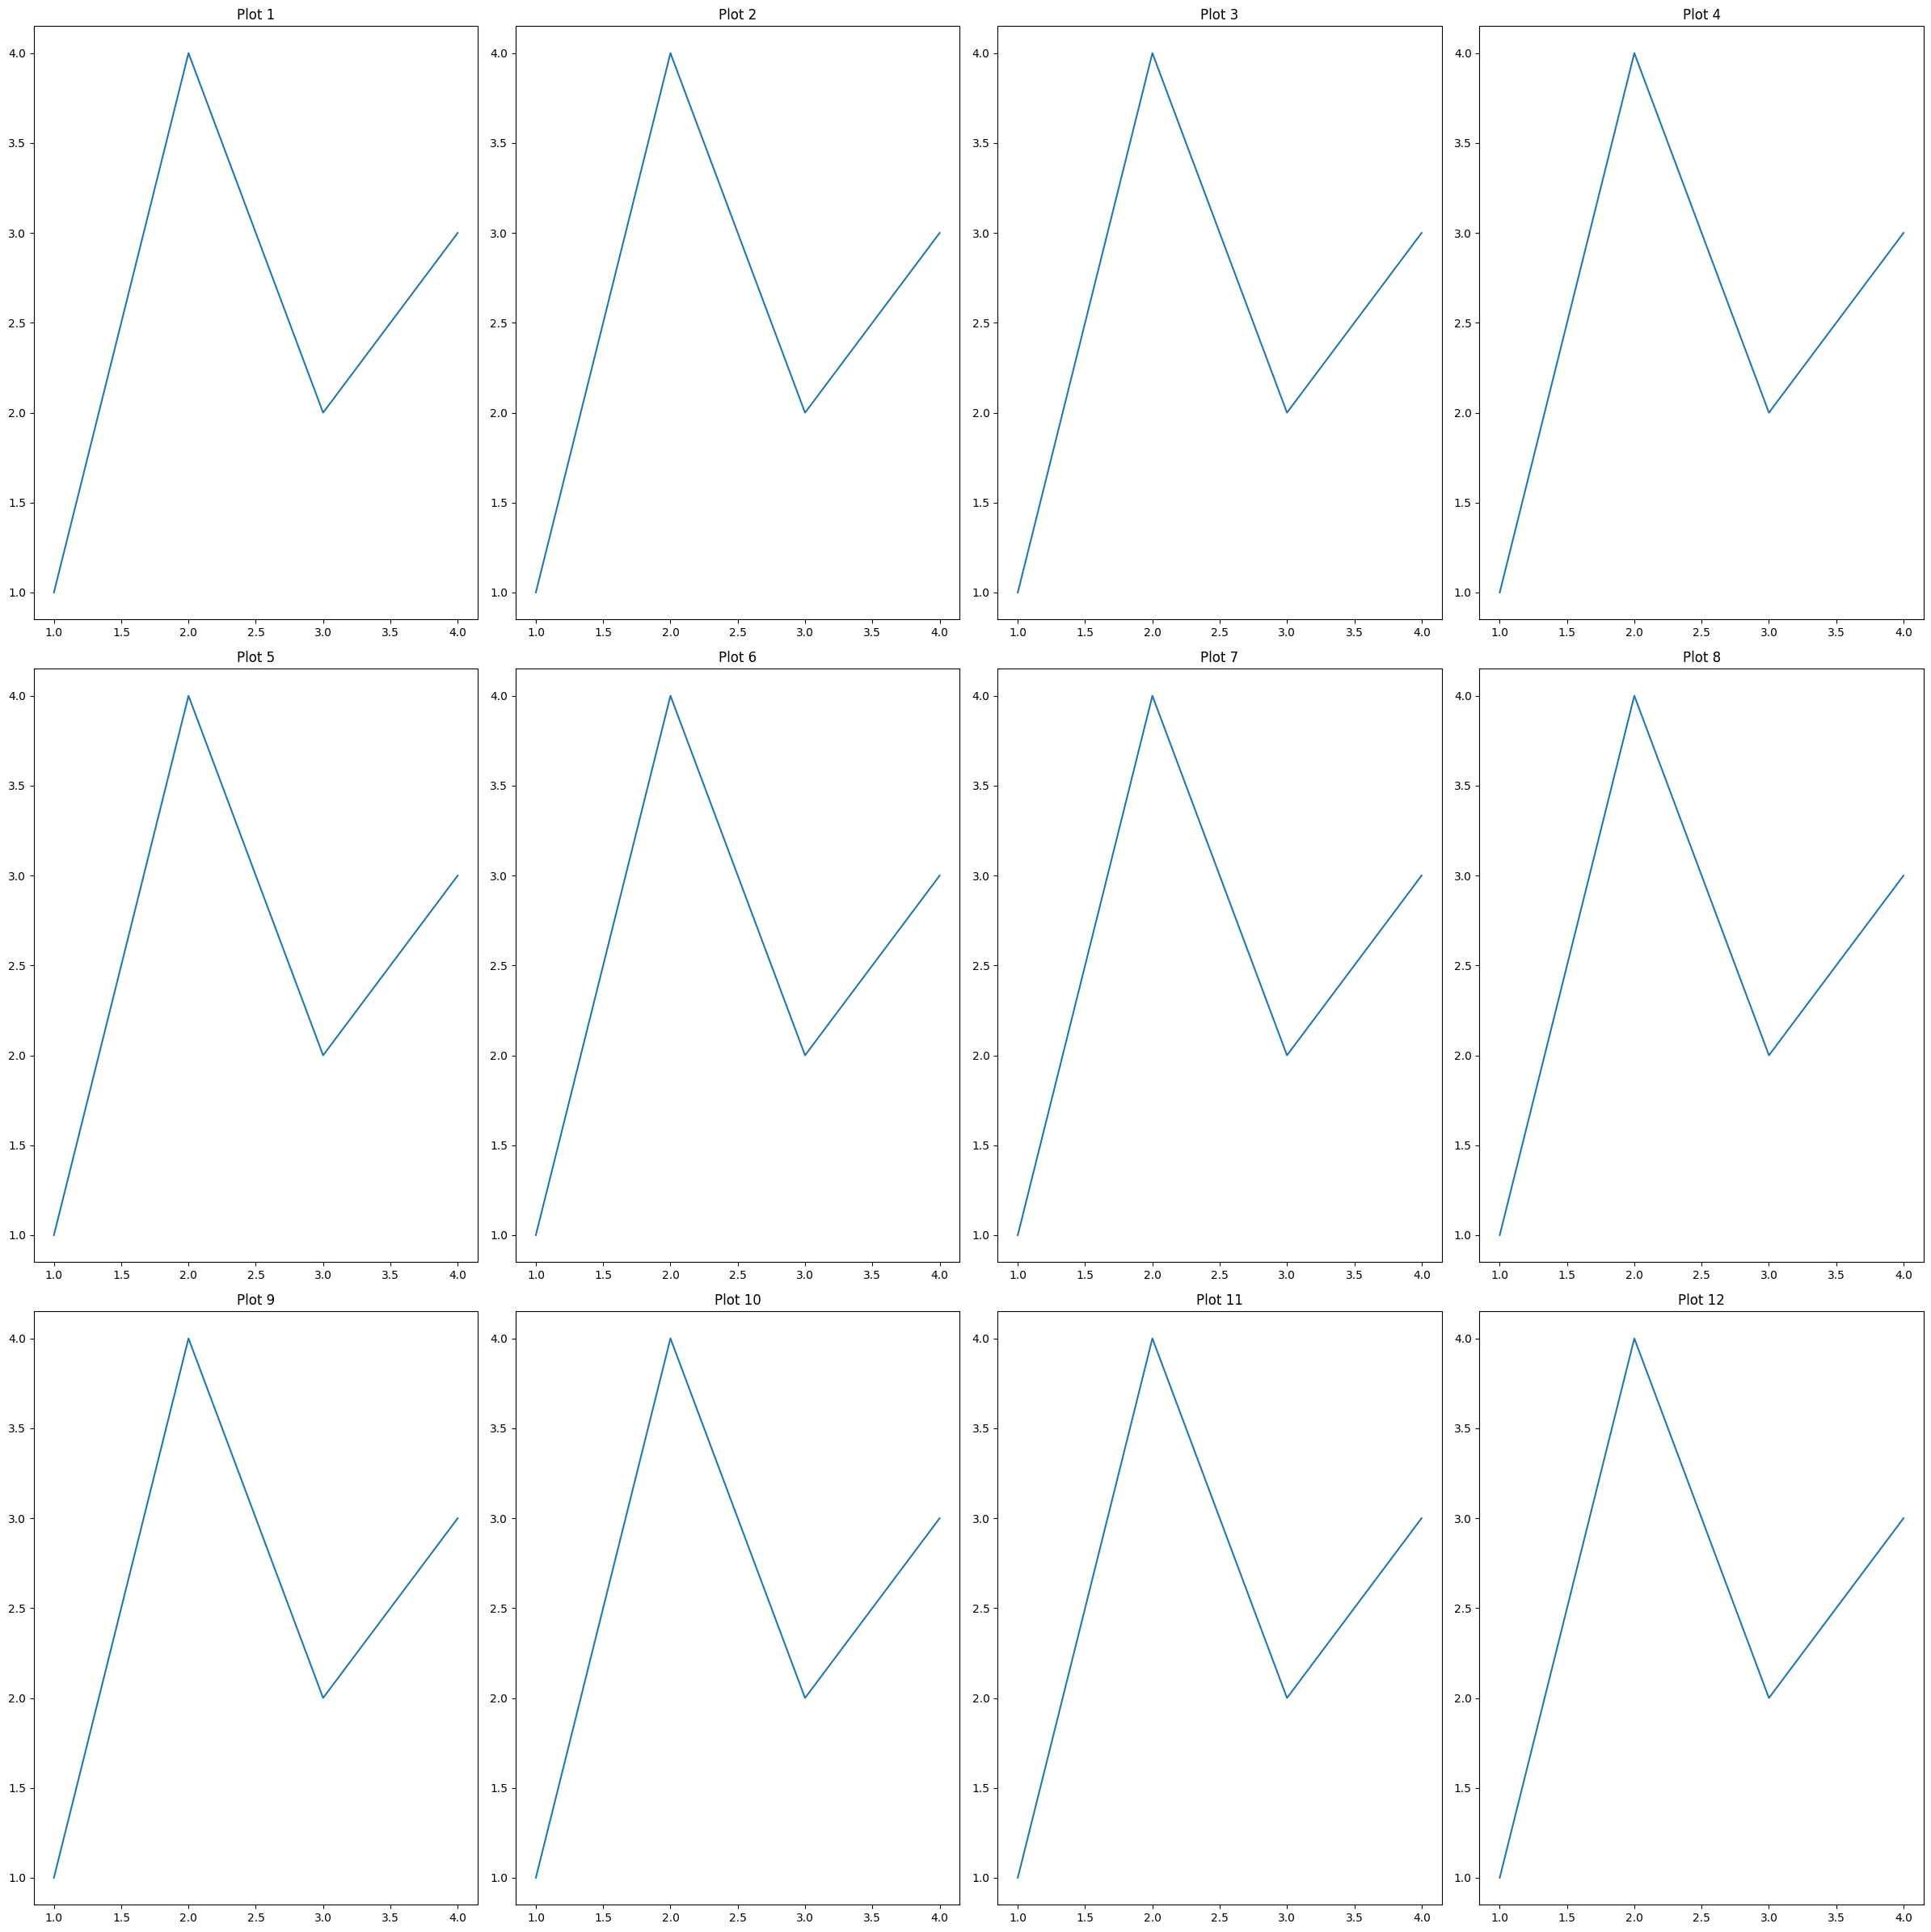

In [62]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=4)

# Iterate over the subplots and plot something
for i, ax in enumerate(axes.flat):
    ax.plot([1, 2, 3, 4], [1, 4, 2, 3])  # Example plot
    ax.set_title(f"Plot {i+1}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()